In [100]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

from umap import UMAP

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8,4)

SEED = 42

In [143]:
class ClassForAssignment_3:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.data_scaled = None
        self.data_pca = None
        self.data_tsne = None
        self.data_umap = None
        self._load_data()
    
    def _load_data(self):
        self.data = pd.read_csv(self.file_path, index_col=0)  # Change this line based on your file format
        
    def normalize_data(self):
        scl = StandardScaler()
        self.data_scaled = scl.fit_transform(self.data)

    def pca_dimensionality_reduction(self):
        print('Selecting optimal number of components for PCA...')
        pca = PCA(random_state=SEED)
        pca.fit(self.data_scaled)
        
        # Calculate explained variance ratio
        explained_variance_ratio = pca.explained_variance_ratio_
        # Calculate cumulative explained variance
        cum_explained_variance = np.cumsum(explained_variance_ratio)
        
        # Plot cumulative explained variance
        plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance, 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Cumulative Explained Variance vs. Number of Components')
        plt.show()

        # Find the optimal number of components
        optimal_n_components = np.argmax(cum_explained_variance >= 0.98) + 1
        print(f"The optimal number of components is {optimal_n_components}.")
        print('\nPerforming PCA....')
        pca = PCA(n_components=optimal_n_components, random_state=SEED)
        self.data_pca = pca.fit_transform(self.data_scaled)
        print('Shape of dataset after performing PCA dimensionality reduction:', self.data_pca.shape)
        print()
        
    def tsne_dimensionality_reduction(self):
        print('Performing TSNE for data visualization:')
        tsne = TSNE(n_components=2, random_state=42)
        self.data_tsne = tsne.fit_transform(self.data_scaled)
        
        # Plot the embedded data
        plt.scatter(self.data_tsne[:, 0], self.data_tsne[:, 1])
        plt.title('TSNE Visualization')
        plt.xlabel('TSNE Component 1')
        plt.ylabel('TSNE Component 2')
        plt.show()
        
        print('Shape of dataset after TSNE dimensionality reduction:', self.data_tsne.shape)
        print()
        
    def umap_dimensionality_reduction(self):
        print('Performing UMAP for data visualization:')
        self.data_umap = UMAP(n_components=3).fit_transform(self.data_scaled)
        
        # Plot the embedded data in 3D
        fig = plt.figure(figsize=(10, 8))  
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.data_umap[:, 0], self.data_umap[:, 1], self.data_umap[:, 2])
        ax.set_title('UMAP Visualization (3D)')
        ax.set_xlabel('UMAP Component 1')
        ax.set_ylabel('UMAP Component 2')
        ax.set_zlabel('UMAP Component 3')
        plt.show()
        
        print('Shape of dataset after UMAP dimensionality reduction:', self.data_tsne.shape)
        print()
    
    # ********* CLUSTERING ****************
    def gaussianmixture(self, method):
        gm = GaussianMixture(n_components=5, random_state=SEED)
        

In [144]:
dataset1 = ClassForAssignment_3("Assignment_3_2023_datasets/dataset1.csv")  # Provide the path to your file here

# 1. Dimensionality Reduction

Selecting optimal number of components for PCA...


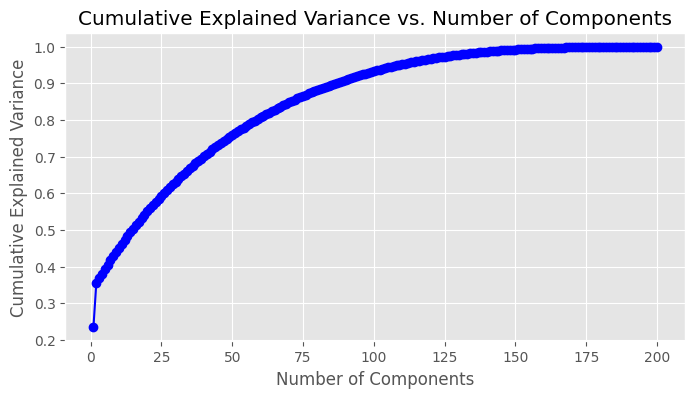

The optimal number of components is 132.

Performing PCA....
Shape of dataset after performing PCA dimensionality reduction: (200, 132)

Performing TSNE for data visualization:


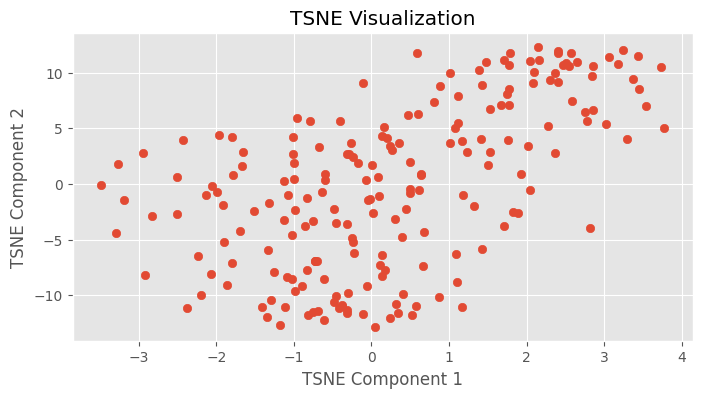

Shape of dataset after TSNE dimensionality reduction: (200, 2)

Performing UMAP for data visualization:


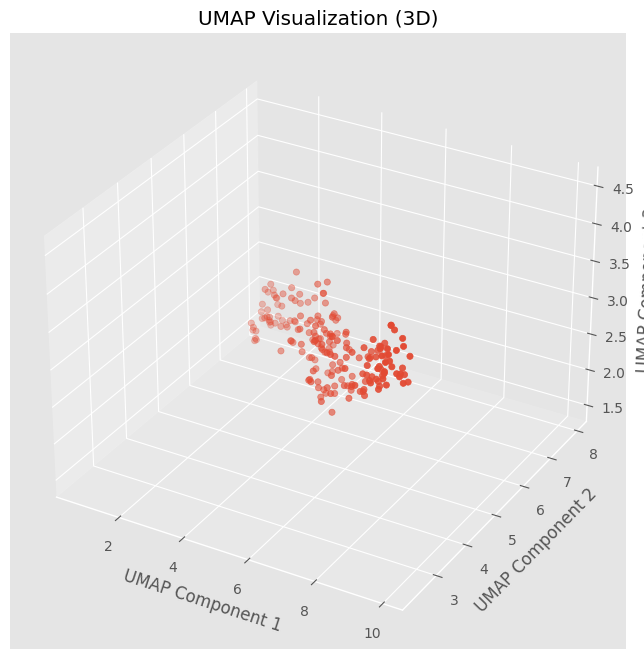

Shape of dataset after UMAP dimensionality reduction: (200, 2)



In [145]:
dataset1.normalize_data()

dataset1.pca_dimensionality_reduction()

dataset1.tsne_dimensionality_reduction()

dataset1.umap_dimensionality_reduction()

# Clustering

In [146]:
X = dataset1.data_pca

In [147]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 5),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, 
    scoring=gmm_bic_score
)

grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 5)},
             scoring=<function gmm_bic_score at 0x7f17f0152820>)

In [148]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]

df["mean_test_score"] = -df["mean_test_score"]

df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)


df['BIC score'] = np.log(df['BIC score'])
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
8,1,diag,9.609767
9,2,diag,9.677532
10,3,diag,9.739366
2,3,spherical,9.741740
1,2,spherical,9.756363


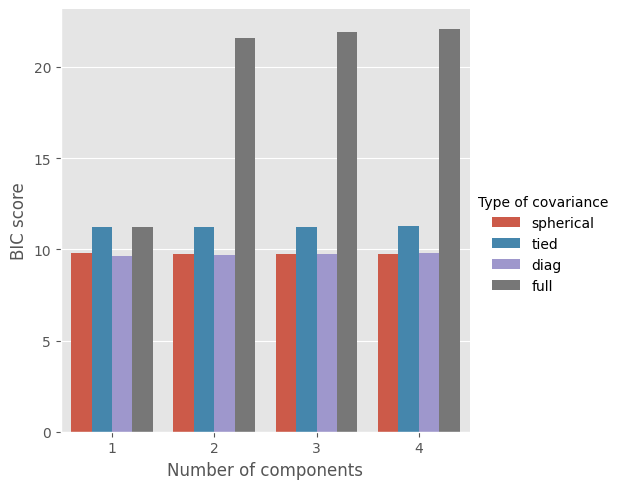

In [149]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [150]:
grid_search.best_estimator_

GaussianMixture(covariance_type='diag')

ValueError: expected square "a" matrix

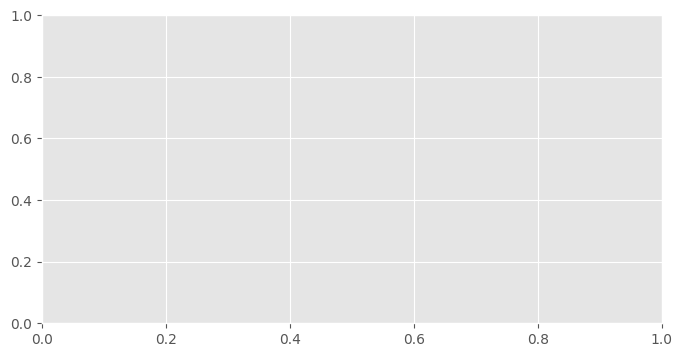

In [151]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()